# Predicting Sepsis Survival Based on Clinical Records

## Summary

To be filled after conclusion

## Introduction

Sepsis is a life-threatening condition that occurs when the immune system overreacts to an infection causing organ dysfunction (Cleveland Clinic, 2022). The reaction can cause damage to tissues and organs and it can lead to severe sepsis from low blood pressure as a result of inflammation throughout the body. The last stage is septic shock which is when blood pressure is so low that it cannot supply enough blood to vital organs such as the brain, kidneys, and liver, causing them to fail and possibly leading to death. Generally, sepsis is usually caused by bacterial infections but it could be from parasites, viruses, and fungi infections in the bloodstream, lungs. and urinary tract (World Health Organization, 2024).  Common symptoms for sepsis include fever, fast heart rate, rapid breathing, low blood pressure, confusion, skin rash, chills and shivering, etc (Canadian Cancer Society, 2024).

Since sepsis requires urgent medical care, a machine learning algorithm that can be used to predict if a patient is likely to survive or pass away after being hospitalized for a specific time interval from septic shock is crucial. Sepsis is often associated with immediate death risk and it can kill patients as fast as within an hour if not treated promptly. An accurate and fast machine learning model will help medical staff prioritize patients who need more urgent care and possibly save more patients from this life-threatening condition. Also, this study aims to identify which factor contributes to whether a patient is more likely to be dead from sepsis. Therefore, if a machine learning algorithm can promptly and accurately classify patients, this could lead to a better sepsis patient prioritization and save more lives.

To answer this question and produce a machine learning model, the datasets of 110,204 admissions of 84,811 hospitalized subjects between 2011 and 2012 in Norway who were diagnosed with infections, systemic inflammatory response syndrome, sepsis by causative microbes, or septic shock will be utilized to analyze and build a machine learning algorithm. It was sourced from the UCI Machine Learning Repository (Chicco & Jurman, 2020). Each row in the data set represents each patient information including their age, sex, and number of prior sepsis episodes. There is an outcome of each patient whether they survive at a time of about 9 days after being hospitalized in each row. All the patients' admissions are only defined by the novel Sepsis-3 definition.

## Methods

EDA is conducted first to see if any data wrangling is needed before proceeding to building a machine learning model.

In [1]:
from utils import *

RANDOM_STATE = 15
sns.set(style="whitegrid")

/Users/eligoze/miniforge3/envs/sepsis_survival_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = load_ucisepsis('s41598-020-73558-3_sepsis_survival_primary_cohort.csv')
test_df = load_ucisepsis('s41598-020-73558-3_sepsis_survival_study_cohort.csv')

train_df.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1


In [3]:
# Rename column names
train_df = train_df.rename(
    columns={
        "age_years": "age",
        "sex_0male_1female": "sex",
        "hospital_outcome_1alive_0dead": "hospital_outcome",
    }
)

test_df = test_df.rename(
    columns={
        "age_years": "age",
        "sex_0male_1female": "sex",
        "hospital_outcome_1alive_0dead": "hospital_outcome",
    }
)

# Convert sex to categorical
train_df["sex"] = train_df["sex"].map({0:"male", 1:"female"})
test_df["sex"] = test_df["sex"].map({0:"male", 1:"female"})

# Convert target to categorical
train_df["hospital_outcome"] = train_df["hospital_outcome"].map({0:"dead", 1:"alive"})
test_df["hospital_outcome"] = test_df["hospital_outcome"].map({0:"dead", 1:"alive"})

In [4]:
# Show the stats of each column
train_df.describe()

,age,episode_number
count,110204.000000,110204.000000
mean,62.735255,1.349379
std,24.126806,0.751799
min,0.000000,1.000000
25%,51.000000,1.000000
50%,68.000000,1.000000
75%,81.000000,1.000000
max,100.000000,5.000000


In [5]:
train_df["sex"].value_counts(True, dropna=False)

sex
male      0.526052
female    0.473948
Name: proportion, dtype: float64

In [6]:
train_df["hospital_outcome"].value_counts(True, dropna=False)

hospital_outcome
alive    0.926455
dead     0.073545
Name: proportion, dtype: float64

In [7]:
# Check if there are any NAs in the train df
train_df.isna().mean()

age                 0.0
sex                 0.0
episode_number      0.0
hospital_outcome    0.0
dtype: float64

From the current train and test datasets, all the data are already clean. Age is an integer from 0 to 100. Sex is either 0 (Male) or 1 (Female). Number of prior Sepsis episodes is an integer ranging from 1 to 5. There are no NA values in any columns, so no data imputation is needed.

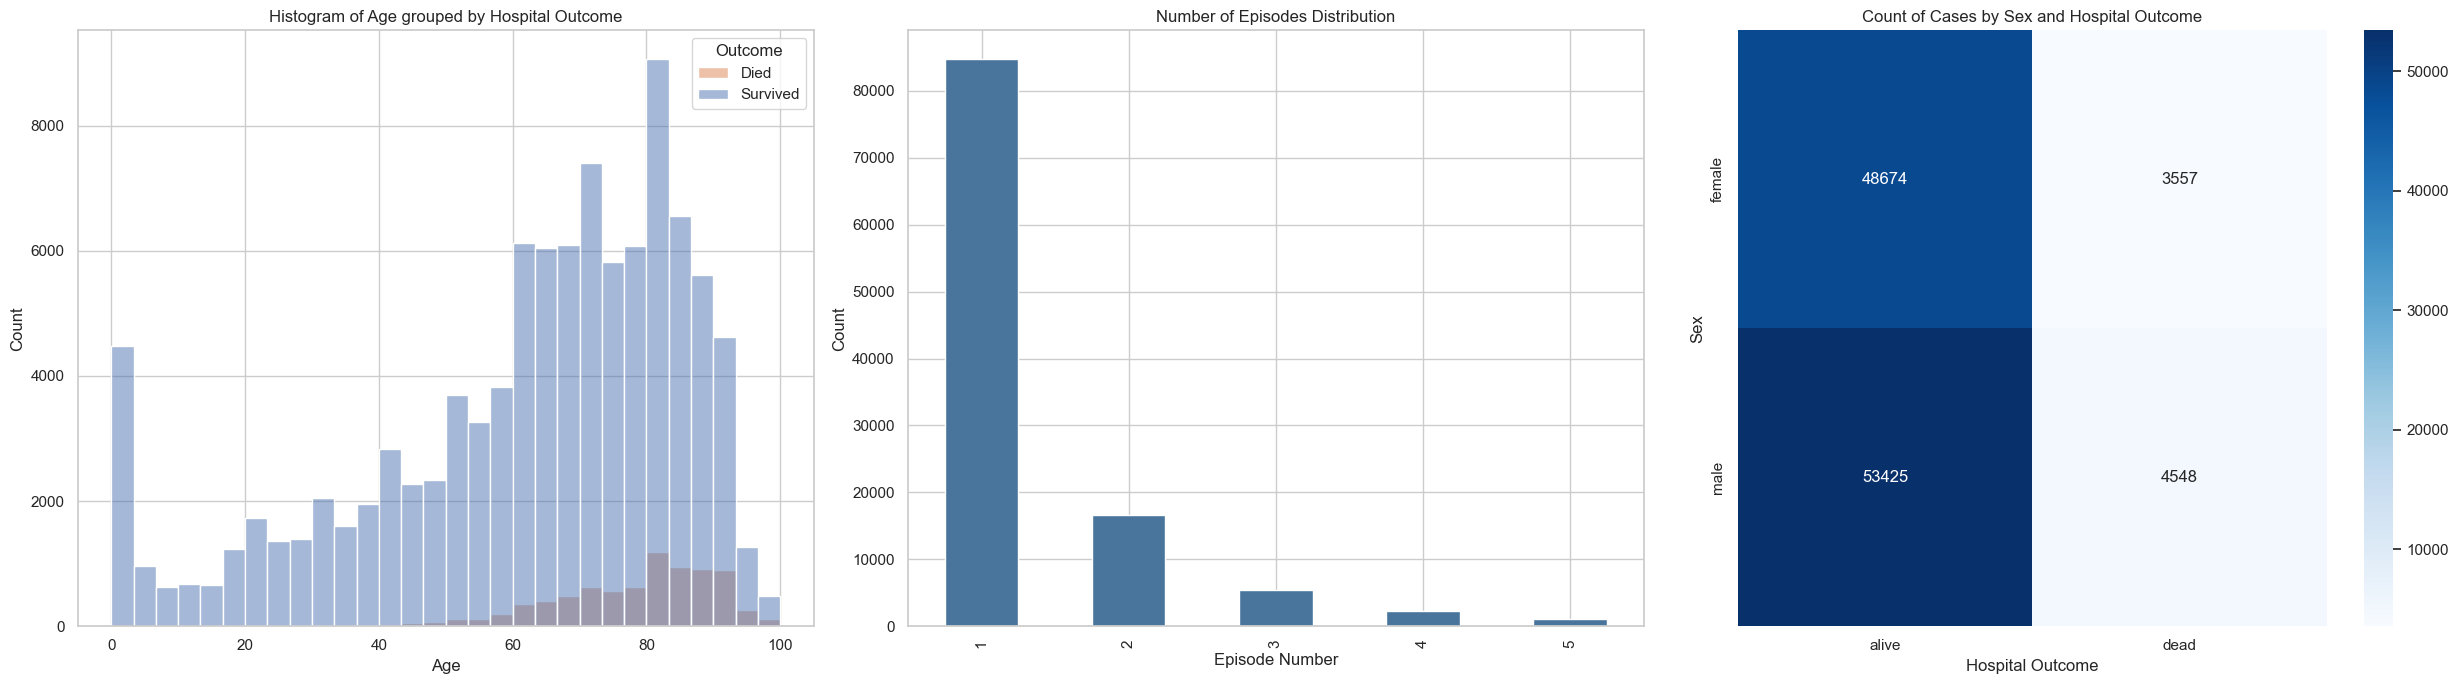

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Histogram of Age grouped by target
sns.histplot(
    data=train_df,
    x="age",
    hue="hospital_outcome",
    bins=30,
    ax=axes[0]
    )
axes[0].set_title("Histogram of Age grouped by Hospital Outcome")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")
axes[0].legend(title="Outcome", labels=["Died", "Survived"])

# Barplot of Number of Episodes
train_df["episode_number"].value_counts().sort_index().plot(
    kind="bar", color="#49759c", ax=axes[1]
)
axes[1].set_title("Number of Episodes Distribution")
axes[1].set_xlabel("Episode Number")
axes[1].set_ylabel("Count")

# Heatmap: Hospital Outcome vs Sex
pivot_sex_target = train_df.pivot_table(
    index="sex",
    columns="hospital_outcome",
    aggfunc="size",
    fill_value=0
)
sns.heatmap(pivot_sex_target, annot=True, fmt=".0f", cmap="Blues", ax=axes[2])
axes[2].set_title("Count of Cases by Sex and Hospital Outcome")
axes[2].set_xlabel("Hospital Outcome")
axes[2].set_ylabel("Sex")

plt.tight_layout()
plt.show()

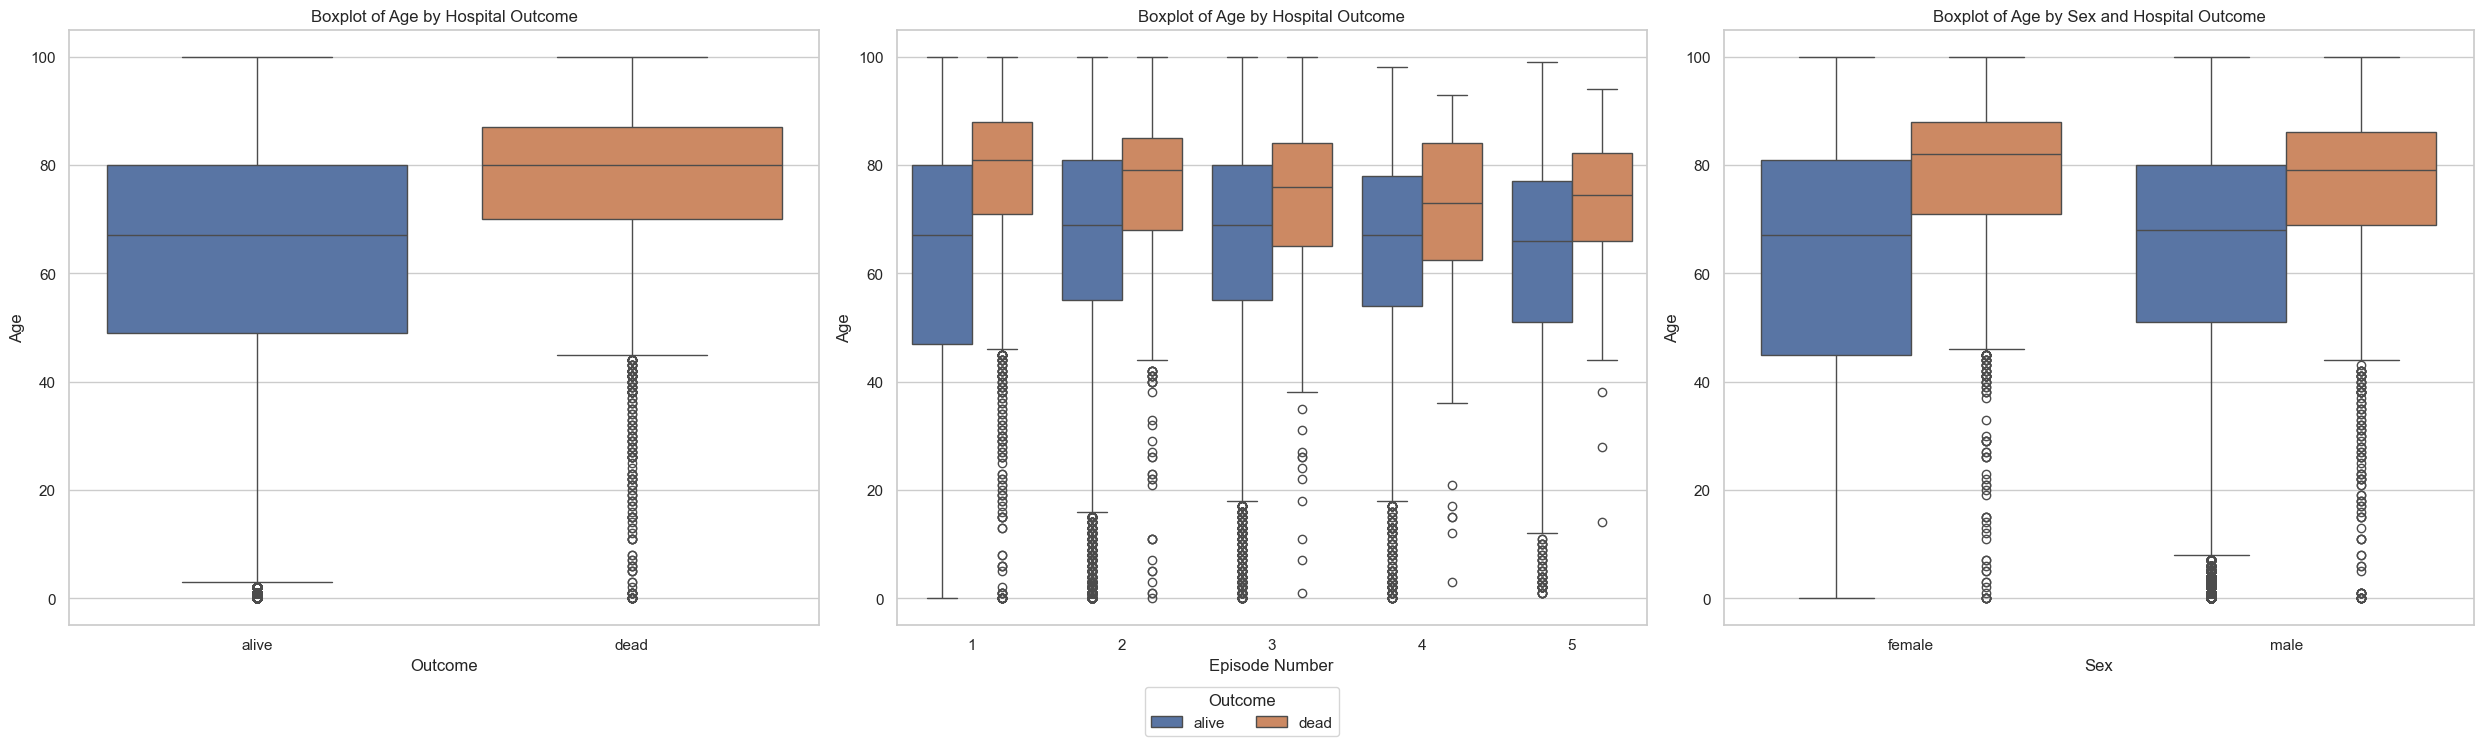

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(25, 7))

# Boxplot of Age by Hospital Outcome
sns.boxplot(
    data=train_df, x="hospital_outcome", y="age", hue="hospital_outcome", ax=axes[0]
)
axes[0].set_title("Boxplot of Age by Hospital Outcome")
axes[0].set_xlabel("Outcome")
axes[0].set_ylabel("Age")

# Boxplot of Age by Hospital Outcome and Episode Number
sns.boxplot(
    data=train_df, x="episode_number", y="age", hue="hospital_outcome", ax=axes[1]
)
axes[1].set_xlabel("Episode Number")
axes[1].set_ylabel("Age")
axes[1].set_title("Boxplot of Age by Hospital Outcome")
axes[1].legend_.remove()
# Boxplot of Age by Sex and Hospital Outcome
sns.boxplot(data=train_df, x="sex", y="age", hue="hospital_outcome")
axes[2].set_xlabel("Sex")
axes[2].set_ylabel("Age")
axes[2].set_title("Boxplot of Age by Sex and Hospital Outcome")
axes[2].legend_.remove()

handles, labels = axes[2].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Outcome",
    loc="lower center",
    ncol=2,
    bbox_to_anchor=(0.5, -0.075),
)

plt.tight_layout()
plt.show()

We can see from the histogram and bar plots above that there is an imbalance of datasets between alive patients and dead patients. This needs to be taken into account when building a machine learning model.

In [19]:
train_df.select_dtypes(["float", "int"]).corr()

,age,episode_number
age,1.000000,0.033857
episode_number,0.033857,1.000000


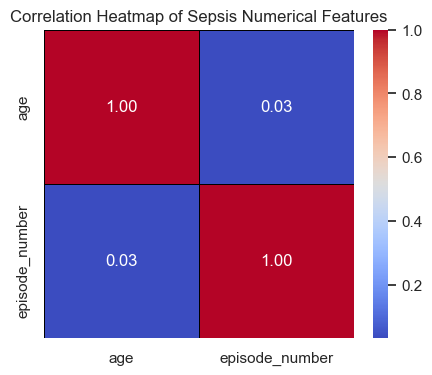

In [20]:
# Calculate the correlation matrix for the selected columns
correlation_matrix = train_df.select_dtypes(["float", "int"]).corr()

# Generate Heat Map
plt.figure(figsize=(5, 4))
sns.heatmap(
    correlation_matrix,
    annot=True,  # Display correlation values
    cmap="coolwarm",  # Use a diverging color map
    fmt=".2f",  # Format numbers to two decimal places
    linewidths=0.5,  # Add lines between cells
    linecolor="black",
)
plt.title("Correlation Heatmap of Sepsis Numerical Features")
plt.show() 

From the correlation heatmap above, it seems like age is the factor that contributes to the hospital outcome the most due to its highest magnitude in correlation. Sex and episode number seem to have lower correlation values compared to age.

## Modeling 

In [6]:
X_train, y_train = (
    train_df.drop(columns=["hospital_outcome"]),
    train_df["hospital_outcome"],
)

X_test, y_test = (
    test_df.drop(columns=["hospital_outcome"]),
    test_df["hospital_outcome"],
)

In [ ]:
numeric_features = ["age", "episode_number"]
categorical_features = ["sex"]
features = numeric_features + categorical_features


lr_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop="if_binary"), categorical_features),
)

In [ ]:
# Tune model
logistic_pipe = make_pipeline(
    lr_preprocessor,
    LogisticRegression(random_state=RANDOM_STATE),
)
param_grid = {
    "logisticregression__C": loguniform(1e-4, 1e2),
    "logisticregression__class_weight": [None, "balanced"],
    "logisticregression__max_iter": [500, 1000, 2000, 3000, 4000, 5000],
}
lr_random_search = RandomizedSearchCV(
    logistic_pipe,
    param_grid,
    n_iter=500,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    return_train_score=True,
    cv=5,
)
lr_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


,estimator,Pipeline(step...m_state=15))])
,param_distributions,"{'logisticregression__C': <scipy.stats....t 0x190ca43b0>, 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__max_iter': [500, 1000, ...]}"
,n_iter,500
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,15
,error_score,nan


In [45]:
# adapted from DSCI 573 lecture 1
# Classification Metrics
lr_best_model = lr_random_search.best_estimator_
y_pred = lr_best_model.predict(X_test)
roc_auc = roc_auc_score(y_test, lr_best_model.predict_proba(X_test)[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

pd.DataFrame(
    {
        "roc auc": [roc_auc],
        "precision": [precision],
        "recall": [recall],
        "F1 score": [f1],
    }
)

,roc auc,precision,recall,F1 score
0,0.587916,0.810719,1.0,0.895466


In [35]:
died = test_df.loc[test_df["hospital_outcome"] == 0]
y_hat_died = lr_best_model.predict_proba(died[features])[:, 1]
survived = test_df.loc[test_df["hospital_outcome"] == 1]
y_hat_survived = lr_best_model.predict_proba(survived[features])[:, 1]

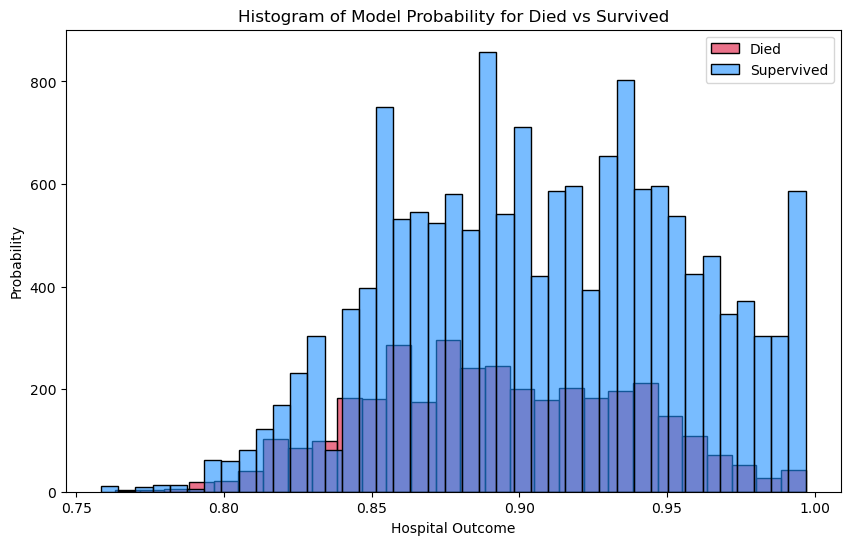

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=y_hat_died, color="orange", kde=False, label = "Died", alpha=0.6)
sns.histplot(data=y_hat_survived, color="dodgerblue", kde=False, label = "Supervived", alpha=0.6)
plt.xlabel("Hospital Outcome")
plt.ylabel("Probability")
plt.legend()
plt.title("Histogram of Model Probability for Died vs Survived")
plt.show()

In [10]:
# saving model
joblib.dump(lr_best_model, "../models/logistic_reg.pkl")

['../models/logistic_reg.pkl']

## Model Explanainability

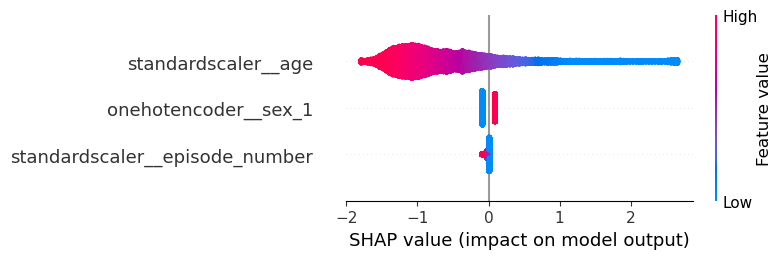

In [43]:
# Transform test set through the preprocessor
X_train_s = lr_best_model.named_steps["columntransformer"].transform(X_train)
X_test_s = lr_best_model.named_steps["columntransformer"].transform(X_test)

# Extract the trained LogisticRegression model
logreg = lr_best_model.named_steps["logisticregression"]

# SHAP explainer
explainer = shap.LinearExplainer(logreg, X_train_s)
shap_values = explainer.shap_values(X_test_s)

# Get feature names from vectorizer + numeric features
feature_names = lr_best_model.named_steps["columntransformer"].get_feature_names_out()

shap.summary_plot(shap_values, X_test_s, feature_names=feature_names)

#### SHAP Explanation and Feature Importance

**SHAP** *(SHapley Additive exPlanations)* is a method used to explain how individual features contribute to a machine learning model’s predictions. It assigns a numerical value to each feature that represents how much that feature pushes the prediction up or down. A higher SHAP value indicates a higher level of importance, meaning the feature has a stronger influence on the model's decision. SHAP is particularly useful for understanding both global feature importance and how a single observation is being predicted. In this analysis, SHAP values are used to determine which features are most important in the logistic regression model predicting sepsis hospital survival.

To interpret the logistic regression model, SHAP values were computed to measure the contribution of each feature to the model’s output. The model includes three predictors: age_in_years, sex, and episode_number. The SHAP values represent the average magnitude by which each feature affects the prediction across all test samples.

The results show that age_in_years is the most important feature, with a mean SHAP value of 0.82624. This clearly indicates that age has the strongest overall influence on the model’s predictions. The feature sex has a mean SHAP value of 0.08918, but this value is relatively small compared to age, suggesting that sex does not meaningfully influence the model’s output. The smallest SHAP value is associated with episode_number, at 0.00859, showing that this feature has almost no effect on the predictions and is effectively ignored by the model.

Overall, the SHAP analysis shows that age_in_years is the dominant predictor used by the model, sex has minimal influence, and episode_number contributes almost nothing to the final prediction. This provides a clear understanding of which features drive the model and confirms that age is the primary factor in predicting sepsis survival outcomes.

## Results & Discussion

## References

- Canadian Cancer Society / Société canadienne du cancer. (2024, January). Sepsis and septic shock. Canadian Cancer Society. https://cancer.ca/en/treatments/side-effects/septic-shock 
- Chicco, D. & Jurman, G. (2020). Sepsis Survival Minimal Clinical Records [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C53C8N.
- Cleveland Clinic. (2022, June). Septic shock: Causes, symptoms & treatment. https://my.clevelandclinic.org/health/diseases/23255-septic-shock
- World Health Organization. (2024, May 3). Sepsis. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/sepsis